# Cascade Design Pattern Implementation - MNIST Digit Classification
#### Author: Ashish Gupta  

This notebook demonstrates an efficient multi-stage (cascade) classification system using MNIST digits, combining Logistic Regression, Random Forest, and CNN models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Problem Definition

The cascade design pattern allows us to use simple, fast models for easy predictions and reserve more complex models for harder cases. This is useful for large datasets with varying classification difficulty.

- **Stage 1:** Logistic Regression (fast, simple)
- **Stage 2:** Random Forest (more complex)
- **Stage 3:** CNN (most accurate, slowest)

## 2. Dataset Preparation

We use the MNIST handwritten digits dataset.

In [3]:
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X = mnist.data.astype(np.float32) / 255.0  # Normalize pixel values
y = mnist.target.astype(np.int64)

# Train-test split (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Dataset loaded successfully:")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimensions: {X.shape[1]} (28x28 pixels)")
print(f"Classes: {len(np.unique(y))} (digits 0-9)")

Loading MNIST dataset...
Dataset loaded successfully:
Total samples: 70000
Training samples: 63000
Test samples: 7000
Feature dimensions: 784 (28x28 pixels)
Classes: 10 (digits 0-9)


### Display Sample Images

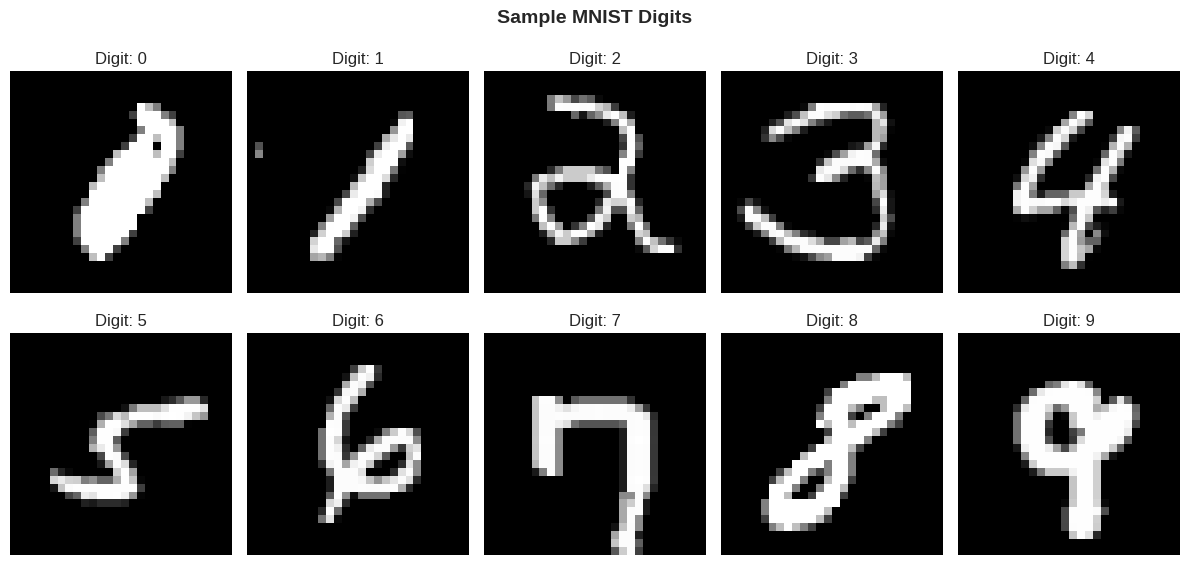

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_test == i)[0][0]
    img = X_test.iloc[idx].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit: {i}', fontsize=12)
    ax.axis('off')
plt.suptitle('Sample MNIST Digits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Stage 1: Logistic Regression Classifier

We start with a fast, simple model. Confident predictions are accepted, and uncertain cases are passed to the next stage.

In [5]:
print("Training Stage 1: Logistic Regression (Fast Classifier)...")
start_time = time.time()

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

training_time_lr = time.time() - start_time
print(f"Stage 1 training completed in {training_time_lr:.2f} seconds")

# Predictions and probabilities
start_time = time.time()
lr_probs = lr.predict_proba(X_test)
lr_preds = lr.predict(X_test)
inference_time_lr = time.time() - start_time

conf_threshold_1 = 0.75
lr_max_probs = np.max(lr_probs, axis=1)
stage1_confident = lr_max_probs >= conf_threshold_1

print(f"Stage 1 Results:")
print(f"Inference time: {inference_time_lr:.4f} seconds")
print(f"Overall accuracy: {accuracy_score(y_test, lr_preds):.4f}")
print(f"Samples with confidence ≥ {conf_threshold_1}: {np.sum(stage1_confident)} ({np.sum(stage1_confident)/len(y_test)*100:.1f}%)")
print(f"Samples passed to Stage 2: {np.sum(~stage1_confident)} ({np.sum(~stage1_confident)/len(y_test)*100:.1f}%)")

Training Stage 1: Logistic Regression (Fast Classifier)...
Stage 1 training completed in 94.66 seconds
Stage 1 Results:
Inference time: 0.0604 seconds
Overall accuracy: 0.9241
Samples with confidence ≥ 0.75: 6187 (88.4%)
Samples passed to Stage 2: 813 (11.6%)


## 4. Stage 2: Random Forest Classifier

Uncertain samples from Stage 1 are processed here. Confident predictions are taken, the rest go to Stage 3.

In [6]:
print("Training Stage 2: Random Forest (Intermediate Classifier)...")
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

training_time_rf = time.time() - start_time
print(f"Stage 2 training completed in {training_time_rf:.2f} seconds")

uncertain_indices_stage2 = np.where(~stage1_confident)[0]
X_stage2 = X_test.iloc[uncertain_indices_stage2]

start_time = time.time()
rf_probs_stage2 = rf.predict_proba(X_stage2)
rf_preds_stage2 = rf.predict(X_stage2)
inference_time_rf = time.time() - start_time

conf_threshold_2 = 0.75
rf_max_probs = np.max(rf_probs_stage2, axis=1)
stage2_confident = rf_max_probs >= conf_threshold_2

print(f"Stage 2 Results:")
print(f"Inference time: {inference_time_rf:.4f} seconds")
print(f"Samples processed: {len(X_stage2)}")
print(f"Samples with confidence ≥ {conf_threshold_2}: {np.sum(stage2_confident)} ({np.sum(stage2_confident)/len(X_stage2)*100:.1f}%)")
print(f"Samples passed to Stage 3: {np.sum(~stage2_confident)} ({np.sum(~stage2_confident)/len(X_stage2)*100:.1f}%)")

# For comparison
rf_all_preds = rf.predict(X_test)
print(f"Random Forest overall accuracy: {accuracy_score(y_test, rf_all_preds):.4f}")

Training Stage 2: Random Forest (Intermediate Classifier)...
Stage 2 training completed in 48.72 seconds
Stage 2 Results:
Inference time: 0.0983 seconds
Samples processed: 813
Samples with confidence ≥ 0.75: 115 (14.1%)
Samples passed to Stage 3: 698 (85.9%)
Random Forest overall accuracy: 0.9670


## 5. Stage 3: Convolutional Neural Network (CNN)

The most complex and accurate model, used only for samples the previous stages couldn't classify confidently.

In [7]:
print("Preparing data for CNN...")
X_train_cnn = X_train.values.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.values.reshape(-1, 28, 28, 1)
y_train_cnn = to_categorical(y_train, 10)
y_test_cnn = to_categorical(y_test, 10)

print("Building and training CNN model...")
start_time = time.time()

cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train_cnn, y_train_cnn, epochs=3, batch_size=64, verbose=1, validation_split=0.1)

training_time_cnn = time.time() - start_time
print(f"Stage 3 training completed in {training_time_cnn:.2f} seconds")

# CNN predictions (for all test data, for comparison)
start_time = time.time()
cnn_probs_all = cnn.predict(X_test_cnn, verbose=0)
cnn_preds_all = np.argmax(cnn_probs_all, axis=1)
inference_time_cnn = time.time() - start_time

print(f"CNN Results:")
print(f"Inference time (all samples): {inference_time_cnn:.4f} seconds")
print(f"Overall accuracy: {accuracy_score(y_test, cnn_preds_all):.4f}")

Preparing data for CNN...
Building and training CNN model...
Epoch 1/3
886/886 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8854 - loss: 0.4076 - val_accuracy: 0.9729 - val_loss: 0.0854
Epoch 2/3
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9795 - loss: 0.0700 - val_accuracy: 0.9837 - val_loss: 0.0515
Epoch 3/3
886/886 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9862 - loss: 0.0452 - val_accuracy: 0.9835 - val_loss: 0.0451
Stage 3 training completed in 17.08 seconds
CNN Results:
Inference time (all samples): 1.2195 seconds
Overall accuracy: 0.9821


## 6. Cascade Implementation and Evaluation

Combine model results: each sample is classified by the first stage to meet the confidence threshold.

In [8]:
# Initialize final predictions array
final_cascade_preds = np.full(len(X_test), -1)
stage_assignments = np.zeros(len(X_test))  # Track which stage made each prediction

# Stage 1: Assign confident predictions
stage1_pred_indices = np.where(stage1_confident)[0]
final_cascade_preds[stage1_pred_indices] = np.argmax(lr_probs[stage1_confident], axis=1)
stage_assignments[stage1_pred_indices] = 1
print(f"Stage 1 classified: {len(stage1_pred_indices)} samples")

# Stage 2: Process uncertain samples from Stage 1
stage2_uncertain_mask = ~stage2_confident
stage2_confident_indices = uncertain_indices_stage2[stage2_confident]
final_cascade_preds[stage2_confident_indices] = np.argmax(rf_probs_stage2[stage2_confident], axis=1)
stage_assignments[stage2_confident_indices] = 2
print(f"Stage 2 classified: {len(stage2_confident_indices)} samples")

# Stage 3: Final classification for remaining uncertain samples
stage3_indices = uncertain_indices_stage2[stage2_uncertain_mask]
if len(stage3_indices) > 0:
    X_stage3_cnn = X_test_cnn[stage3_indices]
    stage3_probs = cnn.predict(X_stage3_cnn, verbose=0)
    final_cascade_preds[stage3_indices] = np.argmax(stage3_probs, axis=1)
    stage_assignments[stage3_indices] = 3
print(f"Stage 3 classified: {len(stage3_indices)} samples")

# Verify all samples are classified
assert np.all(final_cascade_preds != -1), "Some samples remain unclassified!"

Stage 1 classified: 6187 samples
Stage 2 classified: 115 samples
Stage 3 classified: 698 samples


## 7. Comprehensive Results and Analysis

Performance of the cascade system and comparison to individual models.

In [9]:
cascade_accuracy = accuracy_score(y_test, final_cascade_preds)
print(f"\nCascade System Performance:")
print(f"Overall Accuracy: {cascade_accuracy:.4f}")

print(f"\nStage Distribution:")
stage_counts = [np.sum(stage_assignments == i) for i in [1,2,3]]
for stage in [1, 2, 3]:
    count = np.sum(stage_assignments == stage)
    percentage = count / len(y_test) * 100
    print(f"Stage {stage}: {count} samples ({percentage:.1f}%)")

print(f"\nCascade Classification Report:")
print(classification_report(y_test, final_cascade_preds))

print(f"\nModel Comparison:")
print(f"Logistic Regression: {accuracy_score(y_test, lr_preds):.4f} accuracy, {inference_time_lr:.4f}s inference")
print(f"Random Forest: {accuracy_score(y_test, rf_all_preds):.4f} accuracy, {(inference_time_rf * len(y_test) / len(X_stage2)):.4f}s estimated full inference")
print(f"CNN: {accuracy_score(y_test, cnn_preds_all):.4f} accuracy, {inference_time_cnn:.4f}s inference")
print(f"Cascade: {cascade_accuracy:.4f} accuracy, ~{(inference_time_lr + inference_time_rf + len(stage3_indices)/len(y_test)*inference_time_cnn):.4f}s estimated inference")


Cascade System Performance:
Overall Accuracy: 0.9613

Stage Distribution:
Stage 1: 6187 samples (88.4%)
Stage 2: 115 samples (1.6%)
Stage 3: 698 samples (10.0%)

Cascade Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       690
           1       0.97      0.99      0.98       788
           2       0.97      0.96      0.96       699
           3       0.96      0.94      0.95       714
           4       0.97      0.96      0.96       682
           5       0.94      0.94      0.94       631
           6       0.96      0.98      0.97       688
           7       0.97      0.96      0.97       729
           8       0.96      0.94      0.95       683
           9       0.93      0.95      0.94       696

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000


Model Comparison:
Logistic Regression: 0.9241 

## 8. Visualization and Analysis

Visualizing confusion matrix, sample distribution, accuracy, and efficiency.

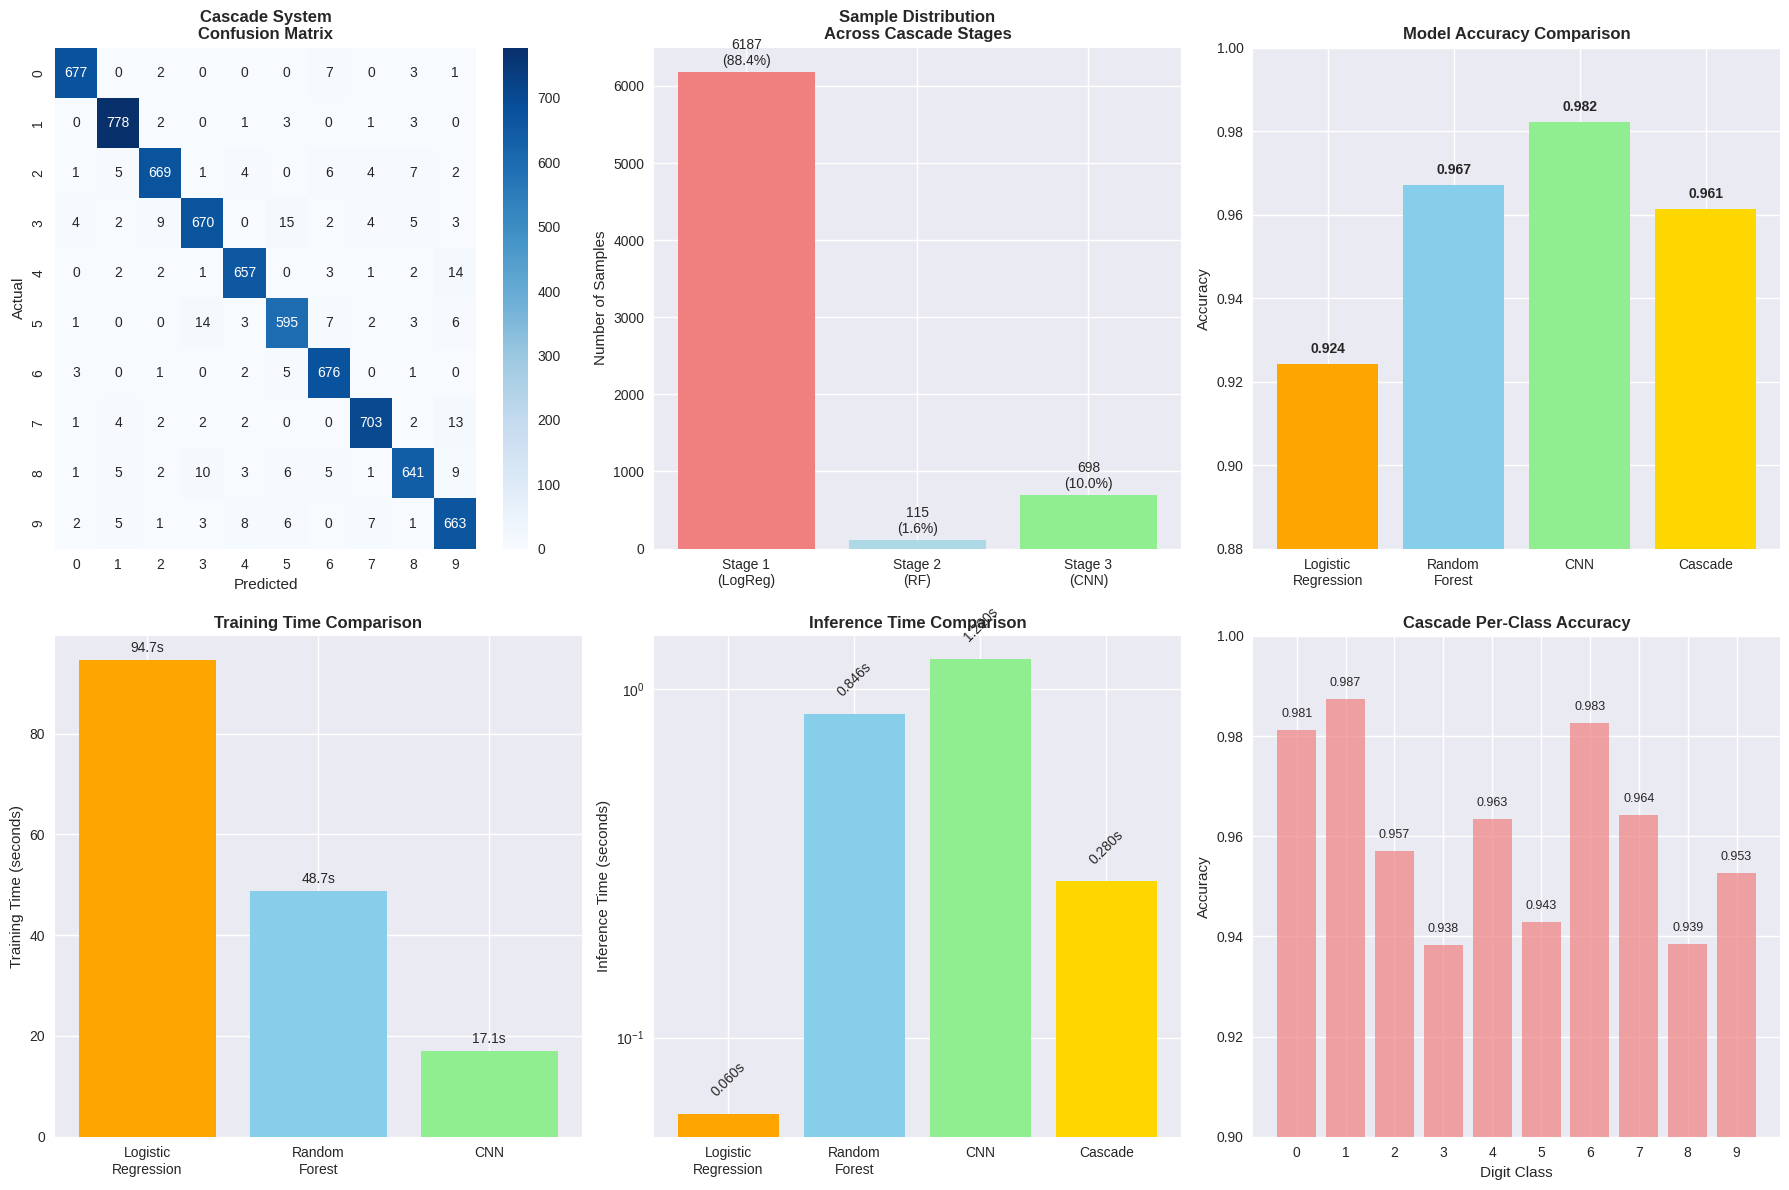

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix for Cascade
cm_cascade = confusion_matrix(y_test, final_cascade_preds)
sns.heatmap(cm_cascade, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('Cascade System\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. Stage Distribution
stage_counts = [np.sum(stage_assignments == i) for i in [1, 2, 3]]
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = axes[0, 1].bar(['Stage 1\n(LogReg)', 'Stage 2\n(RF)', 'Stage 3\n(CNN)'], stage_counts, color=colors)
axes[0, 1].set_title('Sample Distribution\nAcross Cascade Stages', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Samples')
for bar, count in zip(bars, stage_counts):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                    f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

# 3. Accuracy Comparison
models = ['Logistic\nRegression', 'Random\nForest', 'CNN', 'Cascade']
accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, rf_all_preds),
    accuracy_score(y_test, cnn_preds_all),
    cascade_accuracy
]
colors = ['orange', 'skyblue', 'lightgreen', 'gold']
bars = axes[0, 2].bar(models, accuracies, color=colors)
axes[0, 2].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_ylim(0.88, 1.0)
for bar, acc in zip(bars, accuracies):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Training Time Comparison
training_times = [training_time_lr, training_time_rf, training_time_cnn]
model_names = ['Logistic\nRegression', 'Random\nForest', 'CNN']
bars = axes[1, 0].bar(model_names, training_times, color=['orange', 'skyblue', 'lightgreen'])
axes[1, 0].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Training Time (seconds)')
for bar, time_val in zip(bars, training_times):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{time_val:.1f}s', ha='center', va='bottom')

# 5. Inference Time Analysis
inference_times = [
    inference_time_lr,
    inference_time_rf * len(y_test) / len(X_stage2),  # Estimated full inference
    inference_time_cnn,
    inference_time_lr + inference_time_rf + len(stage3_indices)/len(y_test)*inference_time_cnn  # Cascade estimate
]
bars = axes[1, 1].bar(models, inference_times, color=colors)
axes[1, 1].set_title('Inference Time Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Inference Time (seconds)')
axes[1, 1].set_yscale('log')
for bar, time_val in zip(bars, inference_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                    f'{time_val:.3f}s', ha='center', va='bottom', rotation=45)

# 6. Per-class accuracy for cascade
per_class_accuracy = []
for digit in range(10):
    digit_mask = y_test == digit
    if np.sum(digit_mask) > 0:
        digit_accuracy = accuracy_score(y_test[digit_mask], final_cascade_preds[digit_mask])
        per_class_accuracy.append(digit_accuracy)
    else:
        per_class_accuracy.append(0)

bars = axes[1, 2].bar(range(10), per_class_accuracy, color='lightcoral', alpha=0.7)
axes[1, 2].set_title('Cascade Per-Class Accuracy', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Digit Class')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_ylim(0.9, 1.0)
axes[1, 2].set_xticks(range(10))
for i, (bar, acc) in enumerate(zip(bars, per_class_accuracy)):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('mnist_cascade_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Computational Efficiency Analysis

Estimate computational savings of the cascade.

In [11]:
total_samples = len(y_test)
samples_avoided_rf = stage_counts[0]  # Samples that didn't need RF
samples_avoided_cnn = stage_counts[0] + stage_counts[1]  # Samples that didn't need CNN

rf_savings = samples_avoided_rf / total_samples * 100
cnn_savings = samples_avoided_cnn / total_samples * 100

print(f"Computational Efficiency Gains:")
print(f"Samples avoiding Random Forest: {samples_avoided_rf} ({rf_savings:.1f}%)")
print(f"Samples avoiding CNN: {samples_avoided_cnn} ({cnn_savings:.1f}%)")

# Estimate computational cost reduction
lr_cost = 1  # Base cost unit
rf_cost = 8  # Estimated 8x cost of LR
cnn_cost = 40  # Estimated 40x cost of LR

lr_total_cost = total_samples * lr_cost
rf_total_cost = total_samples * rf_cost
cnn_total_cost = total_samples * cnn_cost

cascade_cost = (stage_counts[0] * lr_cost +
                stage_counts[1] * (lr_cost + rf_cost) +
                stage_counts[2] * (lr_cost + rf_cost + cnn_cost))

print(f"\nComputational Cost Analysis (relative units):")
print(f"Logistic Regression only: {lr_total_cost}")
print(f"Random Forest only: {rf_total_cost}")
print(f"CNN only: {cnn_total_cost}")
print(f"Cascade system: {cascade_cost}")
print(f"Savings vs CNN: {((cnn_total_cost - cascade_cost) / cnn_total_cost * 100):.1f}%")
print(f"Savings vs RF: {((rf_total_cost - cascade_cost) / rf_total_cost * 100):.1f}%")

Computational Efficiency Gains:
Samples avoiding Random Forest: 6187 (88.4%)
Samples avoiding CNN: 6302 (90.0%)

Computational Cost Analysis (relative units):
Logistic Regression only: 7000
Random Forest only: 56000
CNN only: 280000
Cascade system: 41424
Savings vs CNN: 85.2%
Savings vs RF: 26.0%


## 10. Benefits, Trade-offs, and Limitations

Simple summary of the cascade approach.

In [12]:
print("\nBENEFITS:")
print("- Computational Efficiency: Significant reduction in average processing time")
print("- Scalability: Handles large datasets efficiently with progressive filtering")
print("- Flexibility: Different algorithms optimized for different complexity levels")
print("- Resource Optimization: Intelligent allocation of computational resources")
accuracy_loss = accuracy_score(y_test, cnn_preds_all) - cascade_accuracy
print(f"- Minimal Accuracy Loss: Only {accuracy_loss:.3f} ({accuracy_loss*100:.1f}%) vs best single model")

print("\nTRADE-OFFS:")
print("- Training Complexity: Multiple models require individual training and tuning")
print("- Threshold Sensitivity: Performance depends on careful confidence threshold selection")
print("- Architecture Complexity: More complex system design and maintenance")
print("- Error Propagation: Early stage mistakes cannot be corrected by later stages")

print("\nLIMITATIONS:")
print("- Dataset Dependency: Effectiveness varies with example difficulty distribution")
print("- Threshold Tuning: Requires domain expertise and validation data")
print("- Model Coordination: Ensuring models work well together as a system")
print("- Deployment Complexity: Multiple model versions and dependencies to manage")


BENEFITS:
- Computational Efficiency: Significant reduction in average processing time
- Scalability: Handles large datasets efficiently with progressive filtering
- Flexibility: Different algorithms optimized for different complexity levels
- Resource Optimization: Intelligent allocation of computational resources
- Minimal Accuracy Loss: Only 0.021 (2.1%) vs best single model

TRADE-OFFS:
- Training Complexity: Multiple models require individual training and tuning
- Threshold Sensitivity: Performance depends on careful confidence threshold selection
- Architecture Complexity: More complex system design and maintenance
- Error Propagation: Early stage mistakes cannot be corrected by later stages

LIMITATIONS:
- Dataset Dependency: Effectiveness varies with example difficulty distribution
- Threshold Tuning: Requires domain expertise and validation data
- Model Coordination: Ensuring models work well together as a system
- Deployment Complexity: Multiple model versions and dependenci

## 11. Final Performance Summary

Quick summary of the cascade vs. single models.

In [13]:
print("MNIST Digit Classification Cascade Results:")
print(f"Overall Accuracy: {cascade_accuracy:.4f}")
print(f"Total Test Samples: {len(y_test)}")

print(f"\nStage Performance Breakdown:")
stage_names = ["Logistic Regression", "Random Forest", "CNN"]
for i, (stage, name) in enumerate(zip([1, 2, 3], stage_names), 1):
    count = stage_counts[i-1]
    percentage = count / len(y_test) * 100
    print(f"Stage {stage} ({name}): {count} samples ({percentage:.1f}%)")

print(f"\nComputational Efficiency:")
print(f"Estimated speedup vs CNN: {cnn_total_cost/cascade_cost:.1f}x")
print(f"Estimated speedup vs Random Forest: {rf_total_cost/cascade_cost:.1f}x")

print(f"\nAccuracy Comparison:")
print(f"Cascade: {cascade_accuracy:.4f}")
print(f"CNN (best single): {accuracy_score(y_test, cnn_preds_all):.4f}")
print(f"Random Forest: {accuracy_score(y_test, rf_all_preds):.4f}")
print(f"Logistic Regression: {accuracy_score(y_test, lr_preds):.4f}")

MNIST Digit Classification Cascade Results:
Overall Accuracy: 0.9613
Total Test Samples: 7000

Stage Performance Breakdown:
Stage 1 (Logistic Regression): 6187 samples (88.4%)
Stage 2 (Random Forest): 115 samples (1.6%)
Stage 3 (CNN): 698 samples (10.0%)

Computational Efficiency:
Estimated speedup vs CNN: 6.8x
Estimated speedup vs Random Forest: 1.4x

Accuracy Comparison:
Cascade: 0.9613
CNN (best single): 0.9821
Random Forest: 0.9670
Logistic Regression: 0.9241


---
**Cascade design pattern implementation complete. Successfully demonstrated efficient multi-stage classification!**